In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [7]:
'''INCLUDE TEXT FILE'''
Data = np.genfromtxt("Co-60", comments="#", delimiter=",", filling_values='0')
Efficiencies = np.genfromtxt("efficiency.txt", comments="#", delimiter=",", filling_values='0')

'''Defining energy drops (keV)
This section reads in energy levels and converts them to a matrix containing the energies of gamma rays emitted from all possible energy drops.
''' 
# Creates empty matrix of appropriate dimensions, and reads in data from first line of text file
Energies = np.zeros((len(Data[0]),len(Data[0])))
length_end = len(Data[0])+1
# print(length_end)
for i in range(0,len(Data[0])):
# creates empty vector
    v=0
    for j in range(0,len(Data[0])):
#         Defines energy drops
        k = Data[0,i]-Data[0,j]
        j=j+1
        v=np.append(v,k)
#     Ensures that matrix only contains one copy of each value
    for d in range(0,len(v)):
        if v[d] < 0:
            v[d]=0
#     Adds each vector to empty matrix
    Energies[i]=np.array(v[1:length_end])
# Final energy levels (keV)
print("Energy levels:",'\n',Energies)

'''Feeding Fractions'''
# Create vector from file
F = np.array([Data[1]])
# Normalize fractions
fsum=F.sum()
# print(fsum)
if F.sum()>1:
    for i in range(0,len(F)):
        F[i] = F[i]/float(fsum)
#     else:
#         F[i] = f[i]
print("Feeding fractions:",'\n',F)
# F = np.array([0, 0, 0, 1])

'''Branching Fractions (NORMALIZE)'''
# Create matrix from file
x = np.array(Data[2:6])
# Normalize branching ratios
for i in range(0,len(x)):
    xsum = x[i].sum()
#     print('XSUM', xsum)
    if np.equal(xsum,0)==True:
        for j in range(0,len(x)):
            x[i,j] = x[i,j]
            j=j+1
    else:
        if np.not_equal(xsum,1)==True:
            for j in range(0,len(x)):
                x[i,j] = x[i,j]/float(xsum)   #float(xsum)
                j=j+1
    i=i+1    
print("Branching fractions:",'\n',x)
# X = np.array([[0,0,0,0],[99.9826,0,0,0],[0.0012,0.0076,0,0],[0.000002,99.85,0.0075,0]])

'''Total Efficiency'''
T = np.array(Data[6])
et = T.sum()/64 #for total array
print("Total efficiency:",'\n',et)

'''Peak Efficiencies'''
# Round energy levels to nearest integer
ep = np.rint(Energies)
# print(P)
for i in range(0,len(ep[0])):
    for j in range(0,len(ep[0])):
        if np.not_equal(ep[i,j],0)==True:
            d=ep[i,j]
#             Change D type to integer and value to reflect line number in TRIUMF data 
            D=d.astype(int)-9
#             Change array value to peak efficiency for specified energy
            ep[i,j] = Efficiencies[D,1]
print("Peak efficiencies:",'\n',ep)

'''Conversion Coefficients'''
alpha = np.array(Data[7:11])
print("Conversion coefficients:",'\n',alpha)
###alpha = np.ones((4,4))*0 #no conversion coefficients for toy system

'''Probabilities'''
    # probability of branch decay occuring (accounting for loss through conversion)
c = x/(1+alpha) 
    # probability of peak detected at expected photopeak (decay * peak efficiency)
a = c*ep
print("A:",'\n', a)
    # probability of peak detected anywhere in spectrum (decay * total efficiency)
e = c*et
    # probability of no gamma ray detection (used for summing out)
b = x-e

'''Source disintegration rate'''
r = np.array(Data[11])
R = r.sum()
print("Source disintegration rate:",R)

E = np.identity(len(Data[11]))

'''NO SUMMING'''
Ao = a
Bo = E+b
print("B_o",'\n', Bo)

no = F.dot(Bo)
print("(F . B_o)", '\n',no)
No = E*no
print("N_o",'\n',No)

mo = Bo[0:len(Data[11]),0]
# print(mo)
Mo = E*mo
print("M_o",'\n', Mo)

So = R*No.dot(Ao).dot(Mo)
# print("Peaks without summing:",'\n',So)

'''FIRST ORDER SUMMING'''
A1 = a + a.dot(a)

b1 = b + b.dot(b)
B1 = E+b1

n1 = F.dot(B1)
#print(n1)
N1 = E*n1
#print(N1)

m1 = B1[0:len(Data[11]),0]
#print(m1)
M1 = E*m1
#print(M1)

S1 = R*N1.dot(A1).dot(M1)
# print("Peaks with first order summing:",'\n',S1)

'''FULL SUMMING'''
'''These while loops currently compare float values to zero without a defined tolerance for equality.
I can set the absolute tolerance using np.isclose() or math.isclose(), but I need to decide on a threshold value.'''

    # summing in 
aa = a.dot(a)
asum = aa.sum
# print(asum)
asum = aa.sum(dtype=float)
# print("ASUM",asum)
while (asum > 0):
    a = a + aa
    #print(aa)
    #print(asum)
    aa = np.dot(aa,a)
    asum = aa.sum(dtype=float)
#print(a)
A = a
# print(A)

    # summing out
bb = b.dot(b)
bsum = bb.sum(dtype=float)
# print("BSUM",bsum)
while (bsum > 0):
    b = b + bb
    #print(bb)
    #print(bsum)
    bb = np.dot(bb,b)
    bsum = bb.sum(dtype=int)
#print(b)
B = E + b #kth power
#print(B)

'''Calculating full measured peaks (S)'''

# EQUATION 6

n = F.dot(B)
#print(n)
N = E*n
#print(N)

m = B[0:4,0]
#print(m)
M = E*m
#print(M)

S = R*N.dot(A).dot(M)
print("Measured Peaks:",'\n',S)
print("Peaks without summing:",'\n',So)
# print("Peaks with first order summing:",'\n',S1)
          
# Correction coefficient:
# CC = E+(S-So)/So
# print("CORRECTION COEFFICIENT (no summing):",'\n', CC)

# "false" correction coefficient
    
# FS = S-So
# print("Difference due to full summing correction:",'\n',FS)

# FOS = S1-So
# print("Difference due to first-order summing correction:",'\n',FOS)
      
# FMFO = S-S1
# print("Difference due to full summing compared to first order correction:",'\n',FMFO)
      

Energy levels: 
 [[    0.        0.        0.        0.   ]
 [ 1332.508     0.        0.        0.   ]
 [ 2158.61    826.102     0.        0.   ]
 [ 2505.748  1173.24    347.138     0.   ]]
Feeding fractions: 
 [[  0.00000000e+00   1.19997600e-03   1.99996000e-05   9.98780024e-01]]
Branching fractions: 
 [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.36363636e-01   8.63636364e-01   0.00000000e+00   0.00000000e+00]
 [  2.00285403e-08   9.99924873e-01   7.51070260e-05   0.00000000e+00]]
Total efficiency: 
 0.00625
Peak efficiencies: 
 [[ 0.          0.          0.          0.        ]
 [ 0.10756144  0.          0.          0.        ]
 [ 0.07667133  0.14371242  0.          0.        ]
 [ 0.0676444   0.11635693  0.25770852  0.        ]]
Conversion coefficients: 
 [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
A: 
 [[  0.00000000e+00   0.00000000e+00   0.000000

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in true_divide


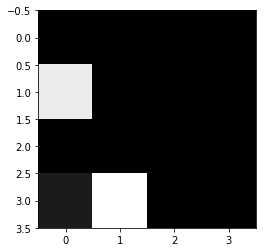

In [58]:
'''Plots of peak intensities'''
'''colormaps: https://matplotlib.org/examples/color/colormaps_reference.html'''
FullPeakIntensity=plt.imshow(S, cmap='gray', interpolation='none')
# plt.show(FullPeakIntensity)

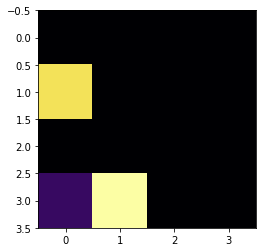

In [59]:
FirstOrderIntensity=plt.imshow(S1, cmap='inferno', interpolation='none')
# plt.show(FirstOrderIntensity)

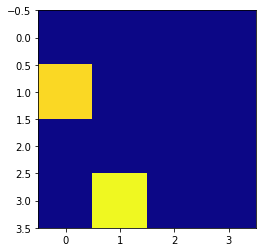

In [61]:
NoCorrectionIntensity=plt.imshow(So, cmap='plasma', interpolation='none')
# plt.show(NoCorrectionIntensity)

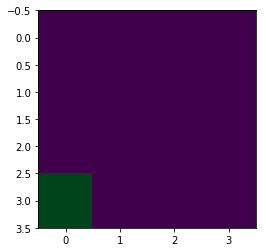

In [62]:
'''Plots of Differences due to summing order'''
FullSumming=plt.imshow(FS, cmap='PRGn', interpolation='none')

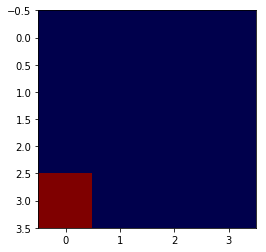

In [64]:
FirstOrder=plt.imshow(FOS, cmap='seismic', interpolation='none')

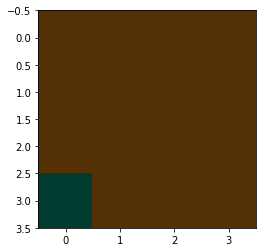

In [66]:
FullMinusFirstOrder=plt.imshow(FMFO, cmap='BrBG', interpolation='none')

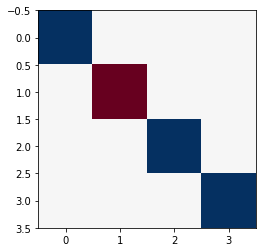

In [57]:
# TEST PLOT 
w = np.array([[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,1]])
colortest=plt.imshow(w, cmap='RdBu', interpolation='none')